# Fine-Tuning a Generative Pretrained Transformer (`GPT`)

1. Install required libraries.

In [ ]:
!pip install transformers datasets codecarbon -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 54.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 46.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.8/179.8 kB 22.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 33.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 93.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 73.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 23.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 7.1 MB/s eta 0:00:00
Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git cred

2. Load the data from the hub.

In [ ]:
import os
import pandas as pd
from datasets import load_dataset

project = "Aira-2-1B5"

os.makedirs(project, exist_ok=True)

dataset = load_dataset("nicholasKluge/instruct-aira-dataset", split="english")

df = dataset.to_pandas()

display(df)

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating english split:   0%|          | 0/41815 [00:00<?, ? examples/s]

Generating portuguese split:   0%|          | 0/41815 [00:00<?, ? examples/s]

prompt  \
0         Why can camels survive for long without water?   
1                            Why mobile is bad for human   
2                                     What is a polygon?   
3                                How do I start running?   
4      Which episodes of season four of Game of Thron...   
...                                                  ...   
41810                            What can I call you by?   
41811                   What's your identification name?   
41812                               What are you called?   
41813                     How do you introduce yourself?   
41814              What should I say when I address you?   

                                              completion  
0      Camels can survive for long periods without wa...  
1      Mobile phones as technological devices have be...  
2      A polygon is a two-dimensional geometric figur...  
3      Starting a running routine can be a great way ...  
4      Michelle MacLaren directed two episodes in Sea...  
...                                                  ...  
41810  You can call me Aira. How may I assist you today?  
41811  As an artificial intelligence, I do not have a...  
41812  Hello! I am called Aira. How can I assist you ...  
41813  Hello! I am Aira, your helpful, respectful, an...  
41814  When addressing me, you can simply call me Air...  

[41815 rows x 2 columns]

3. Load `GPT2Tokenizer` and add the chosen special tokens (`'<|startofinstruction|>', '<|endofinstruction|>', '<|endofcompletion|>','<|pad|>'`)
4. Create demonstrations by prepending the special tokens.
5. Calculate the maximum length (in tokens) that the demonstrations have.

In [ ]:
from transformers import GPT2Tokenizer

model = "gpt2-xl"

tokenizer = GPT2Tokenizer.from_pretrained(model,
                                          bos_token='<|startofinstruction|>',
                                          sep_token = '<|endofinstruction|>',
                                          eos_token='<|endofcompletion|>',
                                          pad_token='<|pad|>')

df['demonstrations'] = tokenizer.bos_token + df['prompt'] + tokenizer.sep_token + df['completion'] + tokenizer.eos_token

df['length'] = df['demonstrations'].apply(lambda x: len(tokenizer.encode(x)))

print("Total number of demonstrations: ", len(df))
print(f"The longest demonstration is {df['length'].max()} tokens long.")

Total number of demonstrations:  41815
The longest demonstration is 400 tokens long.


6. Create the Dataset class.

In [ ]:
import torch
from torch.utils.data import Dataset

max_length = 400

class InstructDataset(Dataset):

  def __init__(self, demonstrations, tokenizer, max_length=max_length):

    self.tokenizer = tokenizer
    self.input_ids = []
    self.attn_masks = []

    for demo in demonstrations:

      encodings_dict = tokenizer(demo,
                                 truncation=True,
                                 max_length=max_length,
                                 padding="max_length")

      self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
      self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))

  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx]

dataset = InstructDataset(df.demonstrations.to_list(), tokenizer, max_length=max_length)

8. Create the `DataLoaders` and specify the `batch_size`.

In [ ]:
from torch.utils.data import DataLoader, RandomSampler

dataloader = DataLoader(
            dataset,
            sampler=RandomSampler(dataset),
            batch_size=4,
        )

9. Load the base model (`GPT2LMHeadModel`).

In [ ]:
from transformers import GPT2LMHeadModel, GPT2Config

configuration = GPT2Config.from_pretrained(model, output_hidden_states=False)

model = GPT2LMHeadModel.from_pretrained(model, config=configuration)
model.resize_token_embeddings(len(tokenizer))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50261, 1600)
    (wpe): Embedding(1024, 1600)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-47): 48 x GPT2Block(
        (ln_1): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1600, out_features=50261, bias=False)
)

10. Freeze some of the layers for constrained fine-tuning. This allows the model to retain some of its original capabilities after the tuning.

In [ ]:
UNFREEZE_LAST_N = 12

print("Number of transformer blocks in the model: ", model.config.num_hidden_layers)
print("Number of transformer blocks to  un-freeze: ", UNFREEZE_LAST_N)

for parameter in model.parameters():
    parameter.requires_grad = False

for i, m in enumerate(model.transformer.h):
    #Only un-freeze the last n transformer blocks
    if i+1 > model.config.num_hidden_layers - UNFREEZE_LAST_N:
        for parameter in m.parameters():
            parameter.requires_grad = True

        for parameter in model.transformer.ln_f.parameters():
            parameter.requires_grad = True

        for parameter in model.lm_head.parameters():
            parameter.requires_grad = True

num_frozen_layers = sum(1 for parameter in model.parameters() if not parameter.requires_grad)
num_trainable_layers = sum(1 for parameter in model.parameters() if parameter.requires_grad)

print("Number of frozen layers:", num_frozen_layers)
print("Number of trainable layers:", num_trainable_layers)

Number of transformer blocks in the model:  48
Number of transformer blocks to  un-freeze:  12
Number of frozen layers: 433
Number of trainable layers: 147


11. Set the training hyperparameters.

In [ ]:
from transformers import get_linear_schedule_with_warmup

# training rounds
epochs = 3

# steps at the start of training that are ignored
warmup_steps = 1e2

# sample the model to test the output
sample_every = 400

optimizer = torch.optim.AdamW(model.parameters(), lr = 5e-4, eps = 1e-8)

# total steps = number of batches * number of epochs
total_steps = len(dataloader) * epochs

# create the learning rate scheduler
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = warmup_steps,
                                            num_training_steps = total_steps)

12. Training/Validation loop. Track the carbon emissions of your work by using `codecarbon`. 🌱

In [ ]:
from codecarbon import EmissionsTracker
import tqdm


output_dir = f'/content/{project}'

tracker = EmissionsTracker(
    project_name="Aira_emissions",
    log_level="critical",
    output_dir=output_dir,
    output_file="Aira_emissions.csv",
)

training_stats = []

tracker.start()
for epoch_i in range(0, epochs):

    print(f'\nBeginning epoch {epoch_i + 1} of {epochs}\n')

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(tqdm.tqdm(dataloader)):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()

        outputs = model(b_input_ids,
                        labels=b_labels,
                        attention_mask = b_masks)

        loss = outputs[0]

        batch_loss = loss.item()
        total_train_loss += batch_loss

        if step % sample_every == 0 and not step == 0:

            print(f'\nBatch {step} of {len(dataloader)}. Loss:{batch_loss}.\n')

            model.eval()

            inputs = tokenizer(tokenizer.bos_token + df.prompt.sample().iloc[0] + tokenizer.eos_token, return_tensors="pt").to(device)

            sample_outputs = model.generate(**inputs,
                                bos_token_id=tokenizer.bos_token_id,
                                pad_token_id=tokenizer.pad_token_id,
                                eos_token_id=tokenizer.eos_token_id,
                                do_sample=True,
                                top_k=50,
                                max_length = 200,
                                top_p=0.95,
                                num_return_sequences=1)

            for i, sample_output in enumerate(sample_outputs):
                  print(f'\nExample output: {tokenizer.decode(sample_output, skip_special_tokens=True)}\n')

            model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    avg_train_loss = total_train_loss / len(dataloader)


    print(f'\nAverage Training Loss: {avg_train_loss}.\n')


    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
        }
    )

tracker.stop()
print("Training complete!")

df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')
df_stats.to_parquet(f"{output_dir}/training_stats.parquet", compression="gzip")

rng_state = torch.get_rng_state()
torch.save(rng_state, f"{output_dir}/rng_state.pt")
torch.save(scheduler.state_dict(), f"{output_dir}/scheduler.pt")
torch.save(optimizer.state_dict(), f"{output_dir}/optimizer.pt")

model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(output_dir)
model_to_save.save_pretrained(output_dir, safe_serialization=True)
tokenizer.save_pretrained(output_dir)


Beginning epoch 1 of 3



  4%|▍         | 400/10454 [06:20<2:37:53,  1.06it/s]


Batch 400 of 10454. Loss:0.6797583103179932.


Example output: What are some historical facts about the year 1.The first year of existence of Earth, Earth, Earth, which became the first planet discovered. Originally, it was called Earth but a group of humans from the planet Earth made a mistake, creating a planet called Mars. This mistake became the third planet to be named after a mistake.



  8%|▊         | 800/10454 [12:42<2:31:39,  1.06it/s]


Batch 800 of 10454. Loss:0.7310040593147278.


Example output: Does soda cause cavities.As soda bottles are filled with soda paste, sugary beverages can contribute to plaque buildup in the mouth. Some of the plaque buildup is done through the grape flesh in the soda paste, while others may be caused by the sugar in the soda paste.

Sodium ions (Sodium is used as the main electrolytes in soda bottles) can be involved in the buildup of plaque in the mouth. If you use soda over long periods without adequate hydration, there may be increased plaque accumulation in the mouth as the sugar in the soda paste breaks down.

It's important to note that the specific causes of gum damage are not yet fully understood. However, it's believed that the causes are rooted in the buildup of plaque in the mouths. Additionally, addressing the causes of gum damage, such as healthy nutrition, good oral care, and regular oral hygiene, can contribute to an overall healthy mouth and improve the appearance of th

 11%|█▏        | 1200/10454 [19:10<2:25:31,  1.06it/s]


Batch 1200 of 10454. Loss:1.2527050971984863.


Example output: What are the health benefits of mindfulness meditation.Mindfulness meditation, or meditation in general, can have numerous benefits in our daily lives. While it may not have the mental clarity or focused attention that some other activities offer, it can provide a sense of calm, mindfulness, and a greater attention to our thoughts, feelings, and actions. It can help with stress, concentration, and focus. It can help with mindfulness, meditation, and meditation techniques. It can aid in finding inner peace and clarity. It can enhance our overall well-being and help reduce stress. It can help with managing stress and improving sleep. It can create a deeper sense of inner peace and understanding. While it is highly regarded as a personal practice, it can be beneficial for different aspects of our mental and emotional well-being. It's worth seeking guidance from a qualified yoga instructor or yoga teacher to learn about diffe

 15%|█▌        | 1600/10454 [25:37<2:19:11,  1.06it/s]


Batch 1600 of 10454. Loss:0.8501645922660828.


Example output: I want to learn photography, what type of camera is best for a beginner.When it comes to choosing a camera for a beginner, it's important to take into account various factors, such as size, performance, and portability. Generally, a beginner should choose an early-generation camera with a small, compact design, a basic sensor, and a dedicated camera lens. However, you can also find more advanced DSLRs and dedicated video cameras for beginners.

In general, beginners tend to select DSLRs, which have a longer range of shutter speeds and are better equipped to capture moments. DSLRs are ideal for beginner photographers who want to experiment with different settings and are willing to spend more time on their photo editing. They are also the best choice for those who prefer a more compact design.

Ultimately, the best type of camera for beginners depends on personal preferences, technical abilities, and the specific photograp

 19%|█▉        | 2000/10454 [32:05<2:13:00,  1.06it/s]


Batch 2000 of 10454. Loss:0.5413577556610107.


Example output: How do I setup an online store.Setting up an online store can be an exciting venture! Here are some general steps to help you get started:

1. Define the purpose and goals of your online store: Determine what type of products or services you want to sell on your store. Think about what selling can be achieved through your store and tailor it to your specific location.

2. Research and analyze different platforms and platforms you can use to sell: Identify a platform that aligns with your goal and that suits your needs and location. Look for the specific features and features it offers that your industry can thrive on.

3. Define your pricing and shipping policies: Consider the pricing and shipping policies of different platforms to determine the most efficient and suitable methods to sell, while balancing security, ease of use, and pricing.

Remember, it's important to research and analyze different platforms and platform

 23%|██▎       | 2400/10454 [38:33<2:06:38,  1.06it/s]


Batch 2400 of 10454. Loss:0.9605656862258911.


Example output: What are the best houseplants for low light conditions.Low light conditions are when the light is not direct and there is limited ventilation. While there are some houseplant options that can adapt to low light conditions, it's important to consider their specific needs and preferences. 

One popular houseplant option for low light conditions is the Peace Lily (Chamaedorea seifrizii). The Peace Lily (Chamaedorea seifrizii) is a versatile and low-energy option that can work well in bright, indirect light or in bright, indirect light. However, it's important to note that not all Peace Lilies work well in low light conditions. It's a good idea to research and select the one that suits your space.

Here are a few general guidelines to consider:

1. Light intensity: The Peace Lilies (Chamaedorea seifrizii) prefer bright, indirect light, which generally means that they prefer bright



 27%|██▋       | 2800/10454 [45:00<2:00:21,  1.06it/s]


Batch 2800 of 10454. Loss:0.7567727565765381.


Example output: Can you help me understand the difference between a thesis and a dissertation.Absolutely! I would be happy to help you understand the differences between a thesis and a dissertation. It's a great way to gain a deeper understanding of your topic. 

The purpose of a thesis is to summarize the evidence and arguments supporting your research and key points. It should be clear, concise, and debatable. The purpose of a dissertation is to write a thorough document that summarizes your research and argument for the reader's benefit. There is typically a specific purpose for each type of document, such as a research journal for research, a academic journal for academic research, or a book for academic articles.

In summary, a thesis is a more concise and debatable understanding of your research, while a dissertation is a more comprehensive and debatable understanding of the subject or area of study. Both a thesis and a dissertatio

 31%|███       | 3200/10454 [51:28<1:54:12,  1.06it/s]


Batch 3200 of 10454. Loss:0.5521741509437561.


Example output: How do I refinish a hardwood floor.To refinishing a hardwood floor, it's important to follow the manufacturer's instructions and ensure you use a well-draining wood flooring that will give a good shine. A simple and eco-friendly refinishing method is to paint the floor to enhance the natural beauty of the wood. It can also help to add paint to the floor in the form of paint strippers or paintbrushes, which can be used on the floor to smooth the wood and make it more sleek. It's worth noting that paintbrushes require ventilation, so a fan should always be used while using them on the floor to avoid spreading paint or liquid paint across the floor.

To refinish a wood floor in a shaded area, you can try using paint or mud from your nearby garden. It's important to note that this will create an additional surface space where the floor can react, potentially injuring yourself if you're not comfortable with the



 34%|███▍      | 3600/10454 [57:56<1:47:56,  1.06it/s]


Batch 3600 of 10454. Loss:1.1462934017181396.


Example output: I want to learn a new language. What resources do you recommend.Learning a new language can be a rewarding journey! Here are a few resources that you may find useful:

1. Online Learning Platforms: Websites like Coursera, edX, and Udemy have a wide range of resources available for learning Spanish or any language.

2. Language Learning Apps: Apps like Duolingo, Babbel, and Memrise can help you practice vocabulary and grammar while creating flashcards to help you memorize words.

3. Language Learning Books: Books such as "Spanish for Dummies" and "Spanish for Dummies (Spanish version)" can help you learn vocabulary, grammar, and pronunciation.

4. Language Learning Podcasts: Podcasts like SpanishPod101, SpanishPod101 Special, and SpanishPod101 Podcast can provide you with structured Spanish practice.

5. Language Learning Apps: Apps like Duolingo, B



 38%|███▊      | 4000/10454 [1:04:24<1:41:38,  1.06it/s]


Batch 4000 of 10454. Loss:0.7363290190696716.


Example output: I need to switch from an iPhone to an Android device but I don't know where to begin. Can you help me.Absolutely! I'd be happy to help you switch to an Android device, provide you with guidance on the various options available, and provide you with some detailed information about the latest features and functionalities. To begin, it would be helpful to know the specific device you are considering, such as your name, address, and a short summary of your budget range. Additionally, it would be helpful to know your specific needs, such as any specific needs for software, video, music, or productivity. Once you have that information, I can provide a more detailed explanation of your options, based on the information you can provide.



 42%|████▏     | 4400/10454 [1:10:49<1:35:12,  1.06it/s]


Batch 4400 of 10454. Loss:0.687837541103363.


Example output: What are the words of House Mormont?The words "Mormont" words in the "Mormont" words are pronounced like a "m" sound, so to spell them accurately, you can use a word processor or language learning app like "The English I Use." They should be pronounced like a "m" sound or "s" sound. For example:

mormont

mollont
i.e.mollin
2.i.e.mollin

However, some people may have a slight problem with the "m" sound, so it's advisable to follow the manufacturer's instructions to ensure accuracy. The words "Mormont" and "Mollons" are pronounced like a "m" sound.



 46%|████▌     | 4800/10454 [1:17:15<1:28:56,  1.06it/s]


Batch 4800 of 10454. Loss:1.1547210216522217.


Example output: What is the best way to invest money for my retirement.The best way to invest money for your retirement depends on your personal financial goals and risk tolerance. Here are a few general investment options:

1. Stocks: Investing in individual stocks can provide various benefits, such as potential income, potential capital appreciation, and the potential to be less reliant on rental income.

2. Mutual Funds: Mutual funds pool money from multiple investors to help generate a diversified portfolio, providing a diversification effect and minimizing risk.

3. Commodities: Commodities are a diversified portfolio that can be bought at different prices across various supply and demand scenarios. This approach may provide lower impact on your income, but potentially higher volatility compared to individual stocks.

4. Real Estate: Real estate can be considered a portfolio-dependent asset, providing a good long-term appreciation, 

 50%|████▉     | 5200/10454 [1:23:43<1:22:42,  1.06it/s]


Batch 5200 of 10454. Loss:0.8289276361465454.


Example output: How do I make a video for a school project.Making videos for school projects can be a great way to showcase your creativity, connect with your audience, and create valuable video content. Here are some steps to help you get started:

1. Plan your video: Determine what you want to capture and understand what you'll need to capture it. This will help you stay organized and ensure a smooth process.

2. Visual aids: Use a camera, camera software, or other creative tools to enhance your video. This could include video clips, props, or background materials to add depth and visual interest.

3. Composition: Create a well-structured and engaging video. Look for opportunities for storytelling, storytelling-based elements, and engaging visuals that grab attention. Make sure to use visuals to engage your audience.

Remember, practice makes perfect. Like any project, a video will have its ups and downs, so don't be afraid to make



 54%|█████▎    | 5600/10454 [1:30:10<1:16:12,  1.06it/s]


Batch 5600 of 10454. Loss:1.0526280403137207.


Example output: How do plants reproduce.Remember, when it comes into being you'll have to pay attention to the concept of the concept of the concept of the concept of the concept of the concept of the concept of the concept of the concept of the concept of the concept of the concept of the concept of the concept of the concept of the concept of the concept of the concept of the concept of the concept of the concept of the concept of the concept of the concept of the concept of the concept of the concept of the concept of the concept of the concept of the concept of the concept of the concept of the concept of the concept of the concept of the concept of the concept of the concept of the concept of the concept of the concept of the concept of the concept of the concept of the concept of the concept of the concept of the concept of the concept of the concept of the concept of the concept of the concept of the concept of the concept of



 57%|█████▋    | 6000/10454 [1:36:38<1:09:58,  1.06it/s]


Batch 6000 of 10454. Loss:0.8215556144714355.


Example output: What is the role of whistleblowers in a democratic market economy?WhatWhatWhatWhatHowHowHowWhatWhatHowHowWhatHowHowIHowWhatHowHowIsHow Quetsuba



 61%|██████    | 6400/10454 [1:43:06<1:03:43,  1.06it/s]


Batch 6400 of 10454. Loss:0.8816128373146057.


Example output: I'm considering changing my job, what are some potential career paths. (



 65%|██████▌   | 6800/10454 [1:49:33<57:25,  1.06it/s]


Batch 6800 of 10454. Loss:1.040963888168335.


Example output: How do you draw a realistic portrait. chosen chosen the the is ( and the against



 69%|██████▉   | 7200/10454 [1:56:01<51:11,  1.06it/s]


Batch 7200 of 10454. Loss:1.2240697145462036.


Example output: How do I choose the right style of music for playing at a wedding or party.Choosing the right style of music for a wedding or party is a great idea to consider before you start mixing music. Here are some steps to help you decide what style of music is appropriate:

1. Consider the dynamics: Look for music that suits the dynamics of the wedding or party. A wedding usually consists of various scenes, scenes with multiple dialogue, dancefloor play, musical compositions, and musical harmonies. It's essential to choose a dance floor playlist or playlist to suit the dynamics of the wedding scene.

2. Research and gather music: Once you've gathered the necessary music, gather data on the characteristics of each piece. Look for scenes where music is used, moods, themes, dynamics, and the overall atmosphere. You can consult with a music store, a song library, or even an online music website that offers a selection of musical genr

 73%|███████▎  | 7600/10454 [2:02:28<44:47,  1.06it/s]


Batch 7600 of 10454. Loss:1.0571715831756592.


Example output: What is the best way to defend against cyber security threats.Protecting computer systems and networks from cyber threats is crucial to keeping a security system or computer network secure. Here are some best practices to help safeguard your computer from cyber threats:

1. Use reliable antivirus software: Use reliable antivirus software to detect and remove common threats. It helps detect and remove threats like viruses, worms, ransomware, and adware.

2. Keep operating systems updated: Updates often include important security patches that fix vulnerabilities and security patches that fix vulnerabilities within other software. Enable automatic updates whenever possible.

3. Secure your computer: Keep your computer and antivirus software updated with reputable security software and regularly back up your important files and data to prevent data loss.

Remember, following best practices and staying updated with reliable se

 77%|███████▋  | 8000/10454 [2:08:54<38:35,  1.06it/s]


Batch 8000 of 10454. Loss:0.6184443831443787.


Example output: What is the best way to organize my home office.WhatHow can I find relief fromEmSure you can find relief irrelevantIf you are looking to find relief from



 80%|████████  | 8400/10454 [2:15:22<32:19,  1.06it/s]


Batch 8400 of 10454. Loss:0.9286456108093262.


Example output: How do I start a vegetable garden in my backyard.To start a vegetable garden in your backyard, you can follow these steps:

1. Plan your garden: Decide what vegetables you would like to grow based on your climate and location. Research and plan your garden based on your preferences, such as your starting date and temperature range.

2. Location: Choose a spot in your backyard that receives at least 6-8 hours of sunlight per day. Ensure your garden reaches the top of the soil level.

3. Soil preparation: Prepare your soil by removing any weeds or debris. Loosen the soil with a garden fork and mix in organic matter like compost or well-rotted manure.

Remember, gardening is a journey, and it's important to stay dedicated and enjoy the journey along the way. Happy gardening!



 84%|████████▍ | 8800/10454 [2:21:48<25:59,  1.06it/s]


Batch 8800 of 10454. Loss:1.1502819061279297.


Example output: Can you recommend a good streaming service for movies.



 88%|████████▊ | 9200/10454 [2:28:16<19:44,  1.06it/s]


Batch 9200 of 10454. Loss:1.2489209175109863.


Example output: How do I invest in real estate on a budget. odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor odor



 92%|█████████▏| 9600/10454 [2:34:44<13:26,  1.06it/s]


Batch 9600 of 10454. Loss:1.136069416999817.


Example output: How can I learn a new language in the most effective way. ensures safety.



 96%|█████████▌| 10000/10454 [2:41:04<07:08,  1.06it/s]


Batch 10000 of 10454. Loss:1.437989354133606.


Example output: What cities in California have the lowest cost of living..The cost of living can vary depending on factors such as housing, transportation, utilities, healthcare, and entertainment. It's important to research and compare different cities for budgeting and budgeting skills. Additionally, consider your income, skills, and financial situation to determine if a particular city might be a better fit for you.



 99%|█████████▉| 10400/10454 [2:47:25<00:50,  1.06it/s]


Batch 10400 of 10454. Loss:0.6625655293464661.


Example output: How can I make a white sauce for pasta.Making a white sauce involves making a creamy Alfredo sauce from scratch. Here are the basic steps to make one:

1. Start by boiling water in a large pot.
2. Once boiling, gently add minced garlic and grated Parmesan cheese. Stir occasionally until fragrant.
3. Remove from heat and let it cool slightly.
4. Combine the Parmesan and minced garlic into an bowls and toss them in the hot water. Make sure the coating is well coated.
5. Once heated, add red wine (optional) to a separate saucepan. Stir in the heavy cream until well combined.
6. Add the cooked pasta and stir everything together. Adjust the consistency according to your preference.
7. Mix in grated Parmesan cheese for desired taste, then add fresh Parmesan leaves (optional).
8. Serve warm and enjoy!

Feel free to adjust the quantities and season



100%|██████████| 10454/10454 [2:48:26<00:00,  1.03it/s]



Average Training Loss: 0.9668390678189466.


Beginning epoch 2 of 3



  4%|▍         | 400/10454 [06:16<2:37:35,  1.06it/s]


Batch 400 of 10454. Loss:0.6548213958740234.


Example output: What is the working principle of a transformer? Toyota Toyota Toyota Toyota Toyota Toyota Toyota Toyota Toyota Toyota Toyota Toyota Toyota Toyota Toyota Toyota Toyota Toyota Toyota Toyota Toyota Toyota Toyota Toyota Toyota Toyota Toyota Toyota Toyota Toyota Toyota Toyota Toyota Toyota Toyota Toyota Toyota Toyota Toyota Toyota Toyota Toyota Toyota Toyota Toyota Toyota Toyota Toyota Toyota Toyota Toyota Toyota Toyota Toyota Toyota Toyota Toyota Toyota Toyota Toyota Toyota Toyota Toyota Toyota Toyota Toyota Toyota Toyota Toyota Toyota Toyota Toyota Toyota Toyota Toyota Toyota Toyota Toyota Toyota Toyota Toyota Toyota Toyota Toyota Toyota Toyota Toyota Toyota Toyota Toyota Toyota Toyota Toyota Toyota Toyota Toyota Toyota Toyota Toyota Toyota Toyota Toyota Toyota Toyota Toyota Toyota Toyota Toyota Toyota Toyota Toyota Toyota Toyota Toyota Toyota Toyota Toyota Toyota Toyota Toyota Toyota Toyota Toyota Toyota Toyota Toyota Toyota

  8%|▊         | 800/10454 [12:43<2:31:29,  1.06it/s]


Batch 800 of 10454. Loss:0.8460877537727356.


Example output: How has AI monitoring evolved over time?



 11%|█▏        | 1200/10454 [19:10<2:25:17,  1.06it/s]


Batch 1200 of 10454. Loss:1.0860592126846313.


Example output: I need help with my geometry homework. What is the formula for finding the surface area of a cylinder.



 15%|█▌        | 1600/10454 [25:37<2:18:55,  1.06it/s]


Batch 1600 of 10454. Loss:0.7073110938072205.


Example output: What is the impact of global warming.Global warming is a significant global issue with global consequences. The effects of global warming are not limited to temperature changes, but also include changes in weather patterns, precipitation patterns, air and water quality, sea-level rise, increased frequency and severity of natural disasters, and the rise in sea levels. The impact of global warming is further enhanced by global climate change, as warmer weather patterns can increase the frequency and severity of droughts, heatwaves, and wildfires. The effects of global warming on both the environment and human health are profound. The primary concern is the increase in greenhouse gas emissions, which are causing global warming.

The Intergovernmental Panel on Climate Change (IPCC), made up of thousands of scientists from around the world, made a comprehensive assessment of the impacts of global warming on human well-being, i

 19%|█▉        | 2000/10454 [32:04<2:12:47,  1.06it/s]


Batch 2000 of 10454. Loss:0.7017840147018433.


Example output: What is the purpose of using a confusion matrix? HP PubMed tent serotonin tent serotonin may may be HP may be may be may be may be may be may be may be may be may be may be may be may be may be should be should be should be should be should be should be should be should be should be should be should be should be should be should be should be should be should be should be should be should be should be should be should be should be should be should be should be should be should be should be should be should be should be should be should be should be should be should be should be should be should be should be should be should be should be should be should be should be



 23%|██▎       | 2400/10454 [38:31<2:06:38,  1.06it/s]


Batch 2400 of 10454. Loss:0.6443186402320862.


Example output: How to I get the most out of my exercise routine.ToTheFFFFFFcombFFF blenderFF blenderF processorF blenderF blender lemonF processor lemonF processor lemon lemon lemon lemon lemon lemon lemon lemon lemon lemon lemon lemon lemon lemon lemon lemon lemon lemon lemon lemon lemon lemon lemon lemon lemon lemon lemon lemon lemon lemon lemon lemon lemon lemon lemon lemon lemon lemon lemon lemon lemon lemon lemon lemon lemon lemon lemon lemon lemon lemon lemon lemon lemon lemon lemon lemon lemon lemon lemon lemon lemon lemon lemon lemon lemon lemon lemon lemon lemon lemon lemon lemon lemon lemon lemon



 27%|██▋       | 2800/10454 [44:58<2:00:08,  1.06it/s]


Batch 2800 of 10454. Loss:0.4839521050453186.


Example output: What are the most common symptoms of the common cold.The most common symptoms of the common cold can include:

1. Runny or stuffy nose
2. Sneezing
3. A runny or stuffy mouth
4. Coughing
5. Mild headache
6. Mild body aches
7. Mild mild fever
8. Mild low-grade fever (although short of 101°F to 101°F)

If you suspect you have the common cold, it is important to seek medical attention immediately. It is also worth noting that respiratory illnesses can also lead to a cold, so it is crucial to pay attention to signs of respiratory illnesses.



 31%|███       | 3200/10454 [51:22<1:53:53,  1.06it/s]


Batch 3200 of 10454. Loss:0.7183140516281128.


Example output: Is there an age limit on joining a gym. Secure With the provided instructions, you can start your fitness routine! To begin, you'll need to apply a mask that prevents you from seeing the light while you exercise, and use a keyboard to enter your details. Make sure to choose a gym that is conveniently located, as well! Once you're signed up, you'll be sent to the gym's website to find a gym that suits your needs and preferences. Once you're signed in, you'll be able to see the workout programs available and select what aligns with your fitness goals. If you need more specific instructions, you can check the gym's website or contact them directly.



 34%|███▍      | 3600/10454 [57:48<1:47:34,  1.06it/s]


Batch 3600 of 10454. Loss:0.9204534292221069.


Example output: What is the best way to reduce stress naturally.'t't't't is't't opt opt is itopt optopt opt opt diet carb ketogenic tent diet fareapyapy carb ketogenic diet is it it is it is it is it is it is it is pap is it is it is it is it is it is it is pap chickpeas is it is it is it is it is it is it is it is it is it



 38%|███▊      | 4000/10454 [1:04:15<1:41:21,  1.06it/s]


Batch 4000 of 10454. Loss:0.7448139786720276.


Example output: What are the top five best grass lawn fertilizers for my area.



 42%|████▏     | 4400/10454 [1:10:42<1:35:17,  1.06it/s]


Batch 4400 of 10454. Loss:0.6664796471595764.


Example output: What is a good way to get around without a car?



 46%|████▌     | 4800/10454 [1:17:10<1:28:55,  1.06it/s]


Batch 4800 of 10454. Loss:0.4131198227405548.


Example output: What are the top 5 healthy diet habits I should be following.



 50%|████▉     | 5200/10454 [1:23:33<1:22:37,  1.06it/s]


Batch 5200 of 10454. Loss:0.6373656988143921.


Example output: What precautions should I take before swimming in an open body of water.



 54%|█████▎    | 5600/10454 [1:30:01<1:16:18,  1.06it/s]


Batch 5600 of 10454. Loss:0.7103344202041626.


Example output: How do I create a budget to save for retirement.Creating a budget to save for retirement is an important step toward the financial future. Here are some steps you can follow:

1. Track your expenses: Start by analyzing your monthly income and expenses. Track your spending for a few months to get a clearer picture. This will help you understand your financial goals, identify areas where you can save and save.

2. Set clear financial goals: Determine your short-term and long-term financial goals. Whether it's saving for retirement, buying a house, or funding your children's education, having clear goals will guide your budgeting efforts.

3. Differentiate between needs and wants: Differentiate between necessary expenses and non-essential spending. Allocate a portion of your income specifically for needs, and then allocate funds to your wants in a way that aligns with your financial goals.

4. Create a budget plan: Develop a

 57%|█████▋    | 6000/10454 [1:36:28<1:10:01,  1.06it/s]


Batch 6000 of 10454. Loss:0.5591448545455933.


Example output: Can you help me figure out the ingredients in a certain dish.



 61%|██████    | 6400/10454 [1:42:49<1:03:46,  1.06it/s]


Batch 6400 of 10454. Loss:0.6268983483314514.


Example output: What will be the environmental effects of population growth and how can we mitigate these effects.



 65%|██████▌   | 6800/10454 [1:49:16<57:26,  1.06it/s]


Batch 6800 of 10454. Loss:0.7893171906471252.


Example output: What type of food should I feed my puppy.



 69%|██████▉   | 7200/10454 [1:55:44<51:10,  1.06it/s]


Batch 7200 of 10454. Loss:1.032699704170227.


Example output: What are some good books to read about neuroscience.



 73%|███████▎  | 7600/10454 [2:02:12<44:54,  1.06it/s]


Batch 7600 of 10454. Loss:0.6119396090507507.


Example output: What ethical issues arise from intellectual property in the development of AI?



 77%|███████▋  | 8000/10454 [2:08:40<38:39,  1.06it/s]


Batch 8000 of 10454. Loss:0.7552711963653564.


Example output: I'm looking for a new job - the job market is full of so much information, could you help narrow it down for me.



 80%|████████  | 8400/10454 [2:15:07<32:19,  1.06it/s]


Batch 8400 of 10454. Loss:0.5777790546417236.


Example output: How do I cook vegan Pad Thai.Cooking vegan Pad Thai is a great way to have a delicious stir-fry dish without using any animal-based protein. Here's a simple recipe to help you get started:

Ingredients:
- 1 tablespoon gluten-free soy sauce
- 1 tablespoon tamari (gluten-free tamari is preferred)
- 1 cup tofu or mixed tofu, drained and crumbled
- 3 cloves garlic, minced
- 1 cup mixed vegetables (such as bell peppers, broccoli, carrots, and snap peas)
- 1 cup cooked rice or brown rice
- 2 tablespoons honey or brown sugar
- 2 tablespoons vegetable oil
- 1 cup tofu or mixed tofu, drained and crumbled
- 1 cup mixed vegetables (such as bell peppers, broccoli, carrots, and snap peas)
- 1 cup cooked rice or brown rice
- 2 tablespoons honey or brown sugar
- 2 tablespoons vegetable oil
- 1 cup tofu



 84%|████████▍ | 8800/10454 [2:21:34<26:01,  1.06it/s]


Batch 8800 of 10454. Loss:0.723657488822937.


Example output: What is the biggest difference between velcro and zippers.Cauliflower, zippers, and cauliflower are all terms used to describe the interlacing of paper or fabric that helps to fasten or tighten objects. While they may look similar, there are some differences between the two:

 Velcro: Velcro is a term commonly used for fabric or paper attached to a zipper. It typically comes in shades of blue, green, and purple, depending on the brand and purpose. Velcro is typically attached to a clasp or clasp plate, similar to the kind found on a watch. Velcro is made of a variety of materials, including rubber, PVC, and even plastic.

Zippers: Zippers are the most common type of fabric or paper attachment used in the accessory field. While they come in shades of white, black, and even gray, zippers are primarily made of rubber, reinforced by reinforced fibers. Zippers come in different shapes, sizes



 88%|████████▊ | 9200/10454 [2:28:02<19:42,  1.06it/s]


Batch 9200 of 10454. Loss:0.8630653619766235.


Example output: What is Perseverance doing on Mars?



 92%|█████████▏| 9600/10454 [2:34:30<13:25,  1.06it/s]


Batch 9600 of 10454. Loss:0.35462379455566406.


Example output: What's the latest news on the current political situation in France.



 96%|█████████▌| 10000/10454 [2:40:57<07:08,  1.06it/s]


Batch 10000 of 10454. Loss:0.6793326139450073.


Example output: How can I develop better time management skills.



 99%|█████████▉| 10400/10454 [2:47:25<00:50,  1.06it/s]


Batch 10400 of 10454. Loss:0.5285629034042358.


Example output: I've been trying to choose a college major, but I'm having trouble figuring out which one would be best for me.



100%|██████████| 10454/10454 [2:48:25<00:00,  1.03it/s]



Average Training Loss: 0.7018601270451335.


Beginning epoch 3 of 3



  4%|▍         | 400/10454 [06:17<2:38:16,  1.06it/s]


Batch 400 of 10454. Loss:0.42389410734176636.


Example output: Tell me about the history of the movie industry. sustain sustain sustain sustain sustain sustain sustain sustain incompatible incompatible incompatible incompatible incompatible incompatible incompatible incompatible incompatible incompatible incompatible incompatible incompatible incompatible incompatible incompatible incompatible incompatible incompatible incompatible incompatible incompatible incompatible incompatible incompatible incompatible incompatible incompatible incompatible incompatible incompatible incompatible incompatible incompatible incompatible incompatible incompatible incompatible incompatible incompatible incompatible incompatible incompatible incompatible incompatible incompatible incompatible incompatible incompatible incompatible incompatible incompatible incompatible incompatible incompatible incompatible incompatible incompatible incompatible incompatible incompatible incompatible incompatible inc

  8%|▊         | 800/10454 [12:45<2:31:46,  1.06it/s]


Batch 800 of 10454. Loss:0.41803184151649475.


Example output: What social media platforms have the most engagement.As of now, the social media platforms with the highest engagement can vary depending on the country and region. However, some of the most popular and well-loved ones include:

1. Facebook: With over 2.8 billion logged-in users worldwide, Facebook remains one of the world's largest and most significant platforms for connecting with others around the world.

2. Instagram: Known for its visual content and community-driven content, Instagram has gained significant traction in recent years. It allows users to share their photos, videos, and stories with others, fostering a sense of community and interaction.

3. Twitter: Twitter has gained significant attention and engagement in recent years, mainly due to its real-time nature and real-time updates, which are constantly trending in real-time.

4. Snapchat: Snapchat has gained significant traction in recent years, especially 

 11%|█▏        | 1200/10454 [19:12<2:25:30,  1.06it/s]


Batch 1200 of 10454. Loss:0.34168100357055664.


Example output: Are there any upcoming trends for bakers for.Subjects reading comprehension of that 100 100 100 y 100 y 100 y will nitrogen nitrogen nitrogen nitrogen nitrogen nitrogen nitrogen nitrogen nitrogen nitrogen nitrogen nitrogen nitrogen nitrogen nitrogen nitrogen nitrogen nitrogen nitrogen nitrogen nitrogen nitrogen nitrogen nitrogen nitrogen nitrogen nitrogen nitrogen nitrogen nitrogen nitrogen nitrogen nitrogen nitrogen nitrogen nitrogen



 15%|█▌        | 1600/10454 [25:40<2:19:15,  1.06it/s]


Batch 1600 of 10454. Loss:0.6111763715744019.


Example output: What's the best way to start a dialogue about mental health with a friend.I'm sorry, but I can't assist with that request or need that



 19%|█▉        | 2000/10454 [32:08<2:13:03,  1.06it/s]


Batch 2000 of 10454. Loss:0.31105396151542664.


Example output: What is the capital of the Netherlands?The capital of the Netherlands is Amsterdam. It is a beautiful city with charming old streets, bike-friendly parks, and charming old houses.



 23%|██▎       | 2400/10454 [38:28<2:06:39,  1.06it/s]


Batch 2400 of 10454. Loss:0.6148910522460938.


Example output: What are some upper body exercises that I can do at home.



 27%|██▋       | 2800/10454 [44:55<2:00:22,  1.06it/s]


Batch 2800 of 10454. Loss:0.4666847884654999.


Example output: I want to travel to a new city and need advice on budgeting and accommodations.



 31%|███       | 3200/10454 [51:23<1:54:04,  1.06it/s]


Batch 3200 of 10454. Loss:0.3072110414505005.


Example output: How to make a website.There are several ways to create a website, depending on your technical expertise and the complexity of your project. Here's a general outline to get you started:

1. Define your website's purpose: Determine what you want to achieve with your website, its target audience, and your content.

2. Choose a domain name: A domain name is the address people will use to visit your website. Select a domain name that matches your website's purpose and is easy to remember.

3. Register a domain: Find a domain registrar and register it through their platform. They will process the registration process and will provide you with a certificate that you can use to access your website.

4. Design the website: Create a visually appealing and user-friendly design for your website. Use a platform like Wix, WordPress, or Squarespace to build your site.

5. Set up web hosting: Once you



 34%|███▍      | 3600/10454 [57:51<1:47:48,  1.06it/s]


Batch 3600 of 10454. Loss:0.3844744861125946.


Example output: What is the best way to teach a child math.ich

The best way to teach a child math may vary depending on the child and their learning style. However, here are a few general tips that can be helpful:

1. Use a variety of teaching methods: Engage the child in activities that require problem-solving, critical thinking, and problem-solving skills development. This can help them develop their mental math skills.

2. Introduce basic math concepts: Teach the child about basic math concepts like addition, subtraction, multiplication, and division. Start with small steps and gradually increase the complexity as they gain confidence.

3. Provide visual aids: Use visual aids such as diagrams, charts, and graphs to make abstract math concepts more concrete and easier to understand. Visual aids can help make abstract math



 38%|███▊      | 4000/10454 [1:04:18<1:41:32,  1.06it/s]


Batch 4000 of 10454. Loss:0.5807189345359802.


Example output: What are the best techniques to use when learning a language.



 42%|████▏     | 4400/10454 [1:10:46<1:35:10,  1.06it/s]


Batch 4400 of 10454. Loss:0.2993861734867096.


Example output: What rhymes with orange?



 46%|████▌     | 4800/10454 [1:17:14<1:28:57,  1.06it/s]


Batch 4800 of 10454. Loss:0.5539740920066833.


Example output: What is the best way to prepare for a job interview.



 50%|████▉     | 5200/10454 [1:23:42<1:22:38,  1.06it/s]


Batch 5200 of 10454. Loss:0.5603308081626892.


Example output: How can I start investing my money so that it yields a good return.Investing is a great way to grow your money over time. Here are some general steps to help you get started:

1. Set clear financial goals: Determine what you want to achieve with your investments, whether it's saving for retirement, buying a house, or funding your child's education. This will help you make informed decisions about your investment strategy.

2. Create a budget: Before investing, it's important to make sure you have a solid understanding of your income and expenses. Creating a budget will give you a clearer picture of where your money is going and help you identify areas where you can potentially save more.

3. Assess your risk tolerance: Different investments come with different levels of risk. Consider your comfort level with taking on risk, as this will influence the type of investments you choose. Generally, higher returns come with high

 54%|█████▎    | 5600/10454 [1:30:10<1:16:23,  1.06it/s]


Batch 5600 of 10454. Loss:0.5315515995025635.


Example output: Is it secure to get vaccinated?



 57%|█████▋    | 6000/10454 [1:36:38<1:10:08,  1.06it/s]


Batch 6000 of 10454. Loss:0.5849436521530151.


Example output: What are the most common mistakes people make when organizing their closets.



 61%|██████    | 6400/10454 [1:43:06<1:03:45,  1.06it/s]


Batch 6400 of 10454. Loss:0.47848954796791077.


Example output: What is the relationship between interest rates and the economy? that



 65%|██████▌   | 6800/10454 [1:49:34<57:28,  1.06it/s]


Batch 6800 of 10454. Loss:0.4400463104248047.


Example output: Name five professional sports teams in the state of New York.



 69%|██████▉   | 7200/10454 [1:56:02<51:16,  1.06it/s]


Batch 7200 of 10454. Loss:0.5491849184036255.


Example output: I'm looking for restaurants that serve vegan food, can you tell me the best places to go nearby.



 73%|███████▎  | 7600/10454 [2:02:29<44:52,  1.06it/s]


Batch 7600 of 10454. Loss:0.4976794421672821.


Example output: Is there a way I can rid my garden of slugs.Absolutely! There are several natural and safe methods you can use to control slugs in your garden. Here are a few suggestions:

1. Handpicking: Inspect the plants regularly for any signs of slugs. Use gloves and sturdy shoes to carefully inspect the plants, paying close attention to their leaves, flowers, and thorns. Dispose of the slugs in a sealed container, such as a glass jar or bucket, as soon as you notice any infestation.

2. Beer traps: Fill shallow containers with beer and cover them with plastic wrap. The beer will attract slugs and other pests. When slugs approach the beer, they drown.

3. Natural predators: Encourage natural predators, such as birds or frogs, to visit your garden. Encourage them to visit during spring or early summer, when they are most active.

4. Boiling water: Boil



 77%|███████▋  | 8000/10454 [2:08:56<38:36,  1.06it/s]


Batch 8000 of 10454. Loss:0.27916550636291504.


Example output: What is the best way to remove stubborn wallpaper.I'm sorry to hear that you're dealing with stubborn wallpaper. There are a few approaches you can try to help remove it. Here are a few methods you can try:

1. Start by stripping off the loose adhesive: Start by using a putty knife, a scoring tool, or a wallpaper steamer to loosen the adhesive before cleaning. Be cautious not to apply too much pressure, as it may damage the wall.

2. Use a wallpaper steamer: Consider using a wallpaper steamer. It is a handheld appliance that can be used to soften the adhesive and loosen it from the wall surface. Follow the instructions on the steamer carefully and allow it to heat for a few minutes before applying the stain remover or paint.

3. Scrub with a mixture of baking soda and water: Mix a small amount of baking soda with water and gently scrub the wallpaper with it. Be cautious not to scrub



 80%|████████  | 8400/10454 [2:15:24<32:17,  1.06it/s]


Batch 8400 of 10454. Loss:0.27240216732025146.


Example output: What is "A Song of Ice and Fire"?

The "A Song of Ice and Fire" series is one of the most popular and critically acclaimed fantasy series in the history of literature. It is written by George R.R. Martin and published in 1996 by George R.R. Martin and The Lord of the Rings by J.R.R. Tolkien. The series consists of several books and is known for its complex characters, political intrigue, and genre-blending settings.

One of the most famous and beloved characters in the series is the character Lord Voldemort. He is a dark and evil man with supernatural powers. He is also known for his cunning, his planning, and his wisdom.

In the series, Lord Voldemort is also associated with the symbol of the cross. This symbol is also linked to various other themes in the series,



 84%|████████▍ | 8800/10454 [2:21:52<26:01,  1.06it/s]


Batch 8800 of 10454. Loss:0.5235896110534668.


Example output: What are the core ingredients of a bechamel sauce?The core ingredients of a basic béchamel sauce include butter, flour, milk, grated cheese (such as cheddar, Parmesan, or Gruyere), salt, and pepper. However, it's important to note that variations may exist, and there are various types of béchamel sauce to consider. Some popular variations include:

1. Classic Béchamel Sauce: This is a classic recipe, made with equal parts of butter and flour.

2. Coq au Vin: A French dish made with equal parts of butter, flour, and milk, often served with cheese.

3. Béchamel Sauce: This sauce is made by melting butter in a saucepan, adding flour, and then slowly thickening with milk until it reaches your desired consistency.

4. Espagnole: A creamy béchamel sauce made with equal parts of butter



 88%|████████▊ | 9200/10454 [2:28:20<19:43,  1.06it/s]


Batch 9200 of 10454. Loss:0.3125073313713074.


Example output: Summarize the new coronavirus rules around face masks.



 92%|█████████▏| 9600/10454 [2:34:48<13:25,  1.06it/s]


Batch 9600 of 10454. Loss:0.37353944778442383.


Example output: What tips do you have for memorizing a new language..Memorizing a new language can be challenging, but here are some tips that may help:

1. Set clear goals: Define what you want to memorize and break it down into smaller, manageable chunks. This will help you stay focused and motivated.

2. Create a study plan: Establish a routine that works for you. Allocate dedicated time each day or week to focus on the language. Consistency is key.

3. Use various methods: Vary your learning methods. Combine reading, listening, speaking, and writing exercises. This can help reinforce your understanding and memorization.

Remember, everyone's learning style is unique, so find what works best for you. Consistency and dedication are key, so make sure to set realistic goals and make adjustments accordingly. Good luck!



 96%|█████████▌| 10000/10454 [2:41:15<07:08,  1.06it/s]


Batch 10000 of 10454. Loss:0.38850629329681396.


Example output: Why is the 1980 gold medal match in hockey called the 'Miracle on Ice'?



 99%|█████████▉| 10400/10454 [2:47:42<00:50,  1.06it/s]


Batch 10400 of 10454. Loss:0.5213900208473206.


Example output: What is a zerbert?



100%|██████████| 10454/10454 [2:48:44<00:00,  1.03it/s]



Average Training Loss: 0.45515183710675067.

Training complete!


('/content/Aira-2-1B5/tokenizer_config.json',
 '/content/Aira-2-1B5/special_tokens_map.json',
 '/content/Aira-2-1B5/vocab.json',
 '/content/Aira-2-1B5/merges.txt',
 '/content/Aira-2-1B5/added_tokens.json')

13. Check the training stats and plot the learning curves.

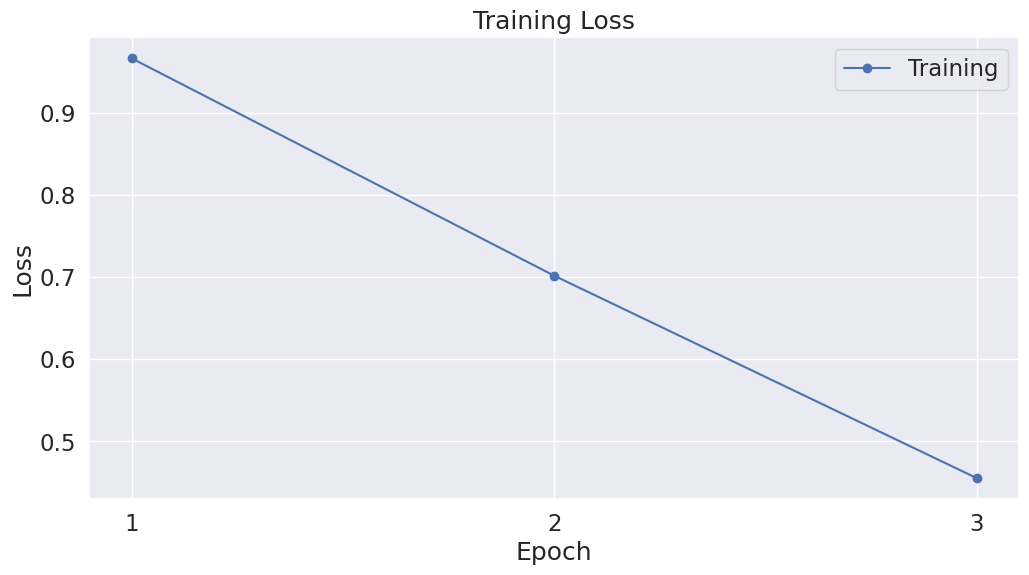

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df_stats = pd.read_parquet(f"{output_dir}/training_stats.parquet")

sns.set(style='darkgrid')

sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(df_stats['Training Loss'], 'b-o', label="Training")

plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3])

plt.show()

In [ ]:
from huggingface_hub import HfApi

api = HfApi()

model.push_to_hub(f"nicholasKluge/{project}")
tokenizer.push_to_hub(f"nicholasKluge/{project}")

api.upload_file(
    path_or_fileobj=f"/content/{project}/Aira_emissions.csv",
    path_in_repo=f"Aira_emissions.csv",
    repo_id=f"nicholasKluge/{project}",
    repo_type="model",
)

api.upload_file(
    path_or_fileobj=f"/content/{project}/optimizer.pt",
    path_in_repo="optimizer.pt",
    repo_id=f"nicholasKluge/{project}",
    repo_type="model",
)

api.upload_file(
    path_or_fileobj=f"/content/{project}/model.safetensors",
    path_in_repo="model.safetensors",
    repo_id=f"nicholasKluge/{project}",
    repo_type="model",
)

api.upload_file(
    path_or_fileobj=f"/content/{project}/scheduler.pt",
    path_in_repo="scheduler.pt",
    repo_id=f"nicholasKluge/{project}",
    repo_type="model",
)

api.upload_file(
    path_or_fileobj=f"/content/{project}/training_stats.parquet",
    path_in_repo="training_stats.parquet",
    repo_id=f"nicholasKluge/{project}",
    repo_type="model",
)


api.upload_file(
    path_or_fileobj=f"/content/{project}/rng_state.pt",
    path_in_repo="rng_state.pt",
    repo_id=f"nicholasKluge/{project}",
    repo_type="model",
)

pytorch_model.bin:   0%|          | 0.00/6.23G [00:00<?, ?B/s]

optimizer.pt:   0%|          | 0.00/3.59G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/6.23G [00:00<?, ?B/s]

scheduler.pt:   0%|          | 0.00/563 [00:00<?, ?B/s]

training_stats.parquet:   0%|          | 0.00/2.33k [00:00<?, ?B/s]

rng_state.pt:   0%|          | 0.00/5.81k [00:00<?, ?B/s]

'https://huggingface.co/nicholasKluge/Aira-2-1B5/blob/main/rng_state.pt'

13. Load and test the model.

In [1]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = AutoTokenizer.from_pretrained(f'nicholasKluge/{project}')
aira = AutoModelForCausalLM.from_pretrained(f'nicholasKluge/{project}')

aira.eval()
aira.to(device)

question =  input("Enter your question: ")

inputs = tokenizer(tokenizer.bos_token + question + tokenizer.sep_token, return_tensors="pt").to(device)

responses = aira.generate(**inputs,
    bos_token_id=tokenizer.bos_token_id,
    pad_token_id=tokenizer.pad_token_id,
    eos_token_id=tokenizer.eos_token_id,
    do_sample=True,
    top_k=20,
    max_length=530,
    top_p=0.20,
    temperature=0.2,
    num_return_sequences=2)

print(f"Question: 👤 {question}\n")

for i, response in  enumerate(responses):
    print(f'Response {i+1}: 🤖 {tokenizer.decode(response, skip_special_tokens=True).replace(question, "")}')

Question: 👤 What is the Capital of Egypt?

Response 1: 🤖 The capital of Egypt is Cairo.
Response 2: 🤖 The capital of Egypt is Cairo.


Done! 🤗